##### Copyright 2018 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Image classification

This tutorial shows how to classify images of flowers using a `tf.keras.Sequential` model and load data using `tf.keras.utils.image_dataset_from_directory`. It demonstrates the following concepts:


* Efficiently loading a dataset off disk.
* Identifying overfitting and applying techniques to mitigate it, including data augmentation and dropout.

This tutorial follows a basic machine learning workflow:

1. Examine and understand data
2. Build an input pipeline
3. Build the model
4. Train the model
5. Test the model
6. Improve the model and repeat the process

In addition, the notebook demonstrates how to convert a [saved model](../../../guide/saved_model.ipynb) to a [TensorFlow Lite](https://www.tensorflow.org/lite/) model for on-device machine learning on mobile, embedded, and IoT devices.

## Setup

Import TensorFlow and other necessary libraries:

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## Download and explore the dataset

This tutorial uses a dataset of about 3,700 photos of flowers. The dataset contains five sub-directories, one per class:

```
flower_photo/
  daisy/
  dandelion/
  roses/
  sunflowers/
  tulips/
```

In [3]:
import pathlib

dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos.tar', origin=dataset_url, extract=True)
data_dir = pathlib.Path(data_dir).with_suffix('')

After downloading, you should now have a copy of the dataset available. There are 3,670 total images:

In [4]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


Here are some roses:

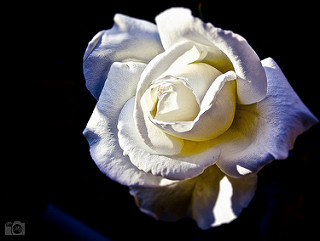

In [5]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

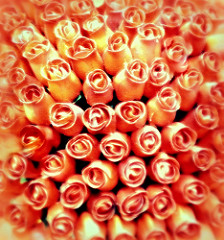

In [6]:
PIL.Image.open(str(roses[1]))

And some tulips:

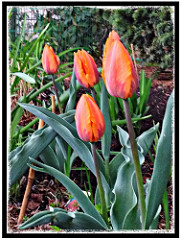

In [7]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

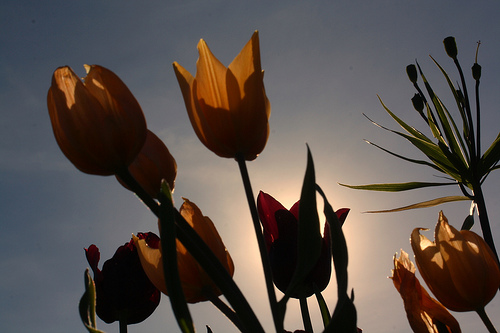

In [8]:
PIL.Image.open(str(tulips[1]))

## Load data using a Keras utility

Next, load these images off disk using the helpful `tf.keras.utils.image_dataset_from_directory` utility. This will take you from a directory of images on disk to a `tf.data.Dataset` in just a couple lines of code. If you like, you can also write your own data loading code from scratch by visiting the [Load and preprocess images](../load_data/images.ipynb) tutorial.

### Create a dataset

Define some parameters for the loader:

In [9]:
batch_size = 32
img_height = 180
img_width = 180

It's good practice to use a validation split when developing your model. Use 80% of the images for training and 20% for validation.

In [10]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [11]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


You can find the class names in the `class_names` attribute on these datasets. These correspond to the directory names in alphabetical order.

In [12]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


## Visualize the data

Here are the first nine images from the training dataset:

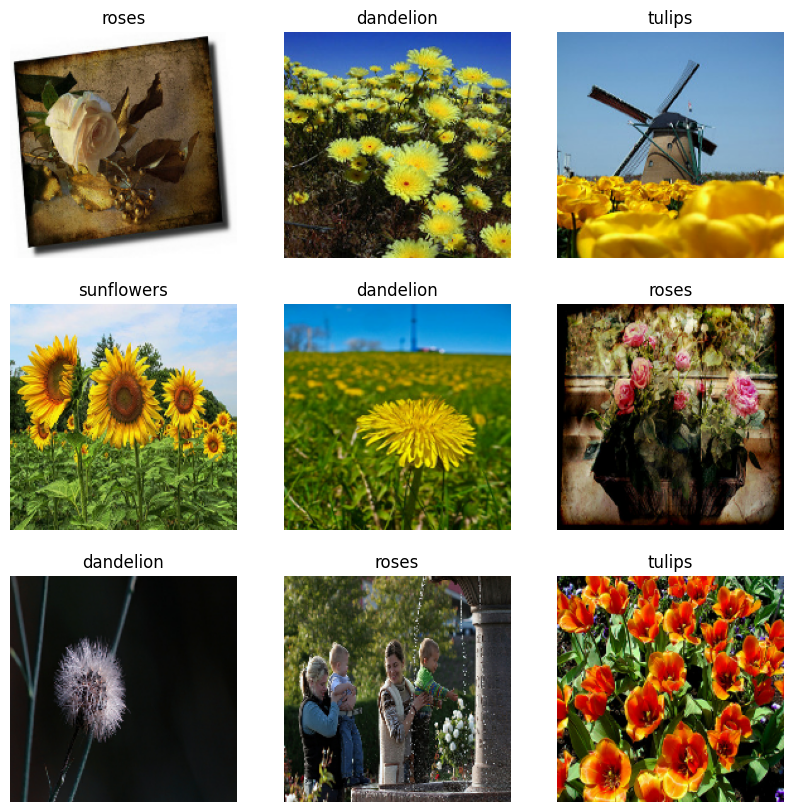

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

You will pass these datasets to the Keras `Model.fit` method for training later in this tutorial. If you like, you can also manually iterate over the dataset and retrieve batches of images:

In [14]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

You can call `.numpy()` on the `image_batch` and `labels_batch` tensors to convert them to a `numpy.ndarray`.


## Configure the dataset for performance

Make sure to use buffered prefetching, so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data:

- `Dataset.cache` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
- `Dataset.prefetch` overlaps data preprocessing and model execution while training.

Interested readers can learn more about both methods, as well as how to cache data to disk in the *Prefetching* section of the [Better performance with the tf.data API](../../guide/data_performance.ipynb) guide.

In [15]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Standardize the data

The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network; in general you should seek to make your input values small.

Here, you will standardize values to be in the `[0, 1]` range by using `tf.keras.layers.Rescaling`:

In [16]:
normalization_layer = layers.Rescaling(1./255)

There are two ways to use this layer. You can apply it to the dataset by calling `Dataset.map`:

In [17]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


Or, you can include the layer inside your model definition, which can simplify deployment. Use the second approach here.

Note: You previously resized images using the `image_size` argument of `tf.keras.utils.image_dataset_from_directory`. If you want to include the resizing logic in your model as well, you can use the `tf.keras.layers.Resizing` layer.

## A basic Keras model

### Create the model

The Keras [Sequential](https://www.tensorflow.org/guide/keras/sequential_model) model consists of three convolution blocks (`tf.keras.layers.Conv2D`) with a max pooling layer (`tf.keras.layers.MaxPooling2D`) in each of them. There's a fully-connected layer (`tf.keras.layers.Dense`) with 128 units on top of it that is activated by a ReLU activation function (`'relu'`). This model has not been tuned for high accuracy; the goal of this tutorial is to show a standard approach.

In [18]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### Compile the model

For this tutorial, choose the `tf.keras.optimizers.Adam` optimizer and `tf.keras.losses.SparseCategoricalCrossentropy` loss function. To view training and validation accuracy for each training epoch, pass the `metrics` argument to `Model.compile`.

In [19]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Model summary

View all the layers of the network using the Keras `Model.summary` method:

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### Train the model

Train the model for 10 epochs with the Keras `Model.fit` method:

In [21]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
92/92 [==============================] - 9s 45ms/step - loss: 1.5315 - accuracy: 0.3134 - val_loss: 1.2685 - val_accuracy: 0.5027
Epoch 2/10
92/92 [==============================] - 2s 19ms/step - loss: 1.1041 - accuracy: 0.5572 - val_loss: 1.0940 - val_accuracy: 0.5599
Epoch 3/10
92/92 [==============================] - 2s 19ms/step - loss: 0.8973 - accuracy: 0.6642 - val_loss: 0.9888 - val_accuracy: 0.6158
Epoch 4/10
92/92 [==============================] - 2s 19ms/step - loss: 0.7143 - accuracy: 0.7367 - val_loss: 0.9952 - val_accuracy: 0.6281
Epoch 5/10
92/92 [==============================] - 2s 19ms/step - loss: 0.5062 - accuracy: 0.8185 - val_loss: 1.1204 - val_accuracy: 0.6104
Epoch 6/10
92/92 [==============================] - 2s 19ms/step - loss: 0.3138 - accuracy: 0.8903 - val_loss: 1.2857 - val_accuracy: 0.6253
Epoch 7/10
92/92 [==============================] - 2s 20ms/step - loss: 0.2092 - accuracy: 0.9343 - val_loss: 1.5546 - val_accuracy: 0.6417
Epoch 8/10
92

## Visualize training results

Create plots of the loss and accuracy on the training and validation sets:

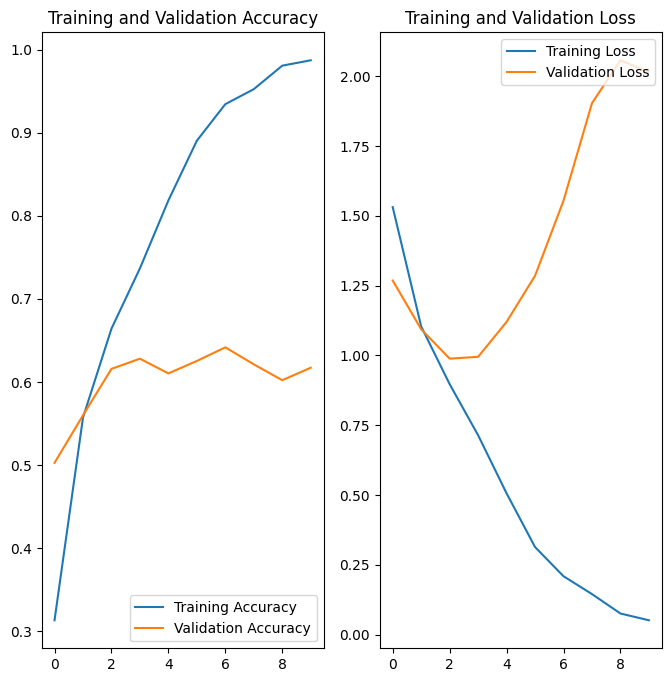

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

The plots show that training accuracy and validation accuracy are off by large margins, and the model has achieved only around 60% accuracy on the validation set.

The following tutorial sections show how to inspect what went wrong and try to increase the overall performance of the model.

## Overfitting

In the plots above, the training accuracy is increasing linearly over time, whereas validation accuracy stalls around 60% in the training process. Also, the difference in accuracy between training and validation accuracy is noticeable—a sign of [overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit).

When there are a small number of training examples, the model sometimes learns from noises or unwanted details from training examples—to an extent that it negatively impacts the performance of the model on new examples. This phenomenon is known as overfitting. It means that the model will have a difficult time generalizing on a new dataset.

There are multiple ways to fight overfitting in the training process. In this tutorial, you'll use *data augmentation* and add *dropout* to your model.

## Data augmentation

Overfitting generally occurs when there are a small number of training examples. [Data augmentation](./data_augmentation.ipynb) takes the approach of generating additional training data from your existing examples by augmenting them using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.

You will implement data augmentation using the following Keras preprocessing layers: `tf.keras.layers.RandomFlip`, `tf.keras.layers.RandomRotation`, and `tf.keras.layers.RandomZoom`. These can be included inside your model like other layers, and run on the GPU.

In [23]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

Visualize a few augmented examples by applying data augmentation to the same image several times:

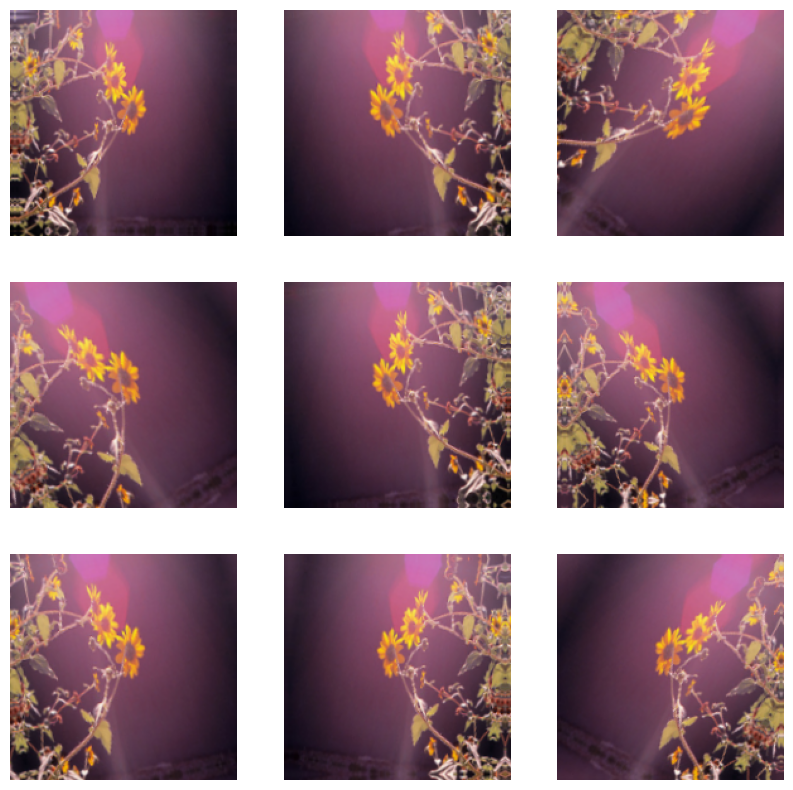

In [24]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

You will add data augmentation to your model before training in the next step.

## Dropout

Another technique to reduce overfitting is to introduce [dropout](https://developers.google.com/machine-learning/glossary#dropout_regularization){:.external} regularization to the network.

When you apply dropout to a layer, it randomly drops out (by setting the activation to zero) a number of output units from the layer during the training process. Dropout takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc. This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer.

Create a new neural network with `tf.keras.layers.Dropout` before training it using the augmented images:

In [25]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

## Compile and train the model

In [26]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [27]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                 

In [28]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
92/92 [==============================] - 5s 31ms/step - loss: 1.3312 - accuracy: 0.4142 - val_loss: 1.1559 - val_accuracy: 0.5286
Epoch 2/15
92/92 [==============================] - 3s 27ms/step - loss: 1.0411 - accuracy: 0.5950 - val_loss: 0.9470 - val_accuracy: 0.6240
Epoch 3/15
92/92 [==============================] - 2s 27ms/step - loss: 0.9556 - accuracy: 0.6287 - val_loss: 0.9475 - val_accuracy: 0.6253
Epoch 4/15
92/92 [==============================] - 2s 27ms/step - loss: 0.8872 - accuracy: 0.6563 - val_loss: 0.9419 - val_accuracy: 0.6567
Epoch 5/15
92/92 [==============================] - 3s 29ms/step - loss: 0.8483 - accuracy: 0.6764 - val_loss: 0.9594 - val_accuracy: 0.6512
Epoch 6/15
92/92 [==============================] - 3s 27ms/step - loss: 0.7916 - accuracy: 0.6894 - val_loss: 0.8613 - val_accuracy: 0.6567
Epoch 7/15
92/92 [==============================] - 2s 27ms/step - loss: 0.7427 - accuracy: 0.7142 - val_loss: 0.8336 - val_accuracy: 0.6812
Epoch 8/15
92

## Visualize training results

After applying data augmentation and `tf.keras.layers.Dropout`, there is less overfitting than before, and training and validation accuracy are closer aligned:

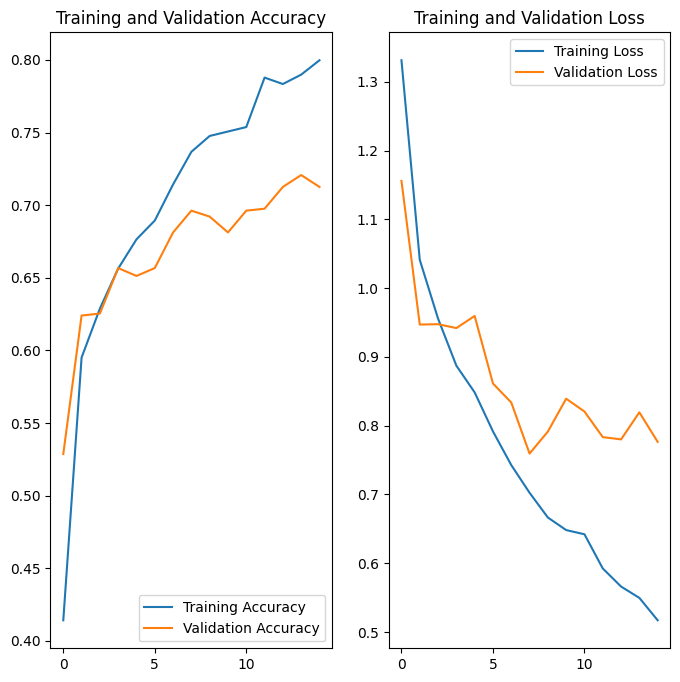

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Predict on new data

Use your model to classify an image that wasn't included in the training or validation sets.

Note: Data augmentation and dropout layers are inactive at inference time.

In [30]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 165ms/step
This image most likely belongs to sunflowers with a 99.34 percent confidence.


# New Model - SeLU   
First, I just tried the dropout method, and changed ReLU to SeLU.

In [31]:
num_classes = len(class_names)

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='selu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='selu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='selu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='selu'),
  layers.Dense(num_classes, name="outputs")
])

In [32]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [33]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                 

In [34]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
92/92 [==============================] - 6s 37ms/step - loss: 2.7400 - accuracy: 0.4247 - val_loss: 1.3380 - val_accuracy: 0.4782
Epoch 2/15
92/92 [==============================] - 3s 34ms/step - loss: 1.1396 - accuracy: 0.5487 - val_loss: 1.0936 - val_accuracy: 0.5817
Epoch 3/15
92/92 [==============================] - 3s 33ms/step - loss: 1.1004 - accuracy: 0.5623 - val_loss: 1.1093 - val_accuracy: 0.5668
Epoch 4/15
92/92 [==============================] - 3s 34ms/step - loss: 1.0619 - accuracy: 0.5794 - val_loss: 1.0143 - val_accuracy: 0.6008
Epoch 5/15
92/92 [==============================] - 3s 34ms/step - loss: 0.9979 - accuracy: 0.6131 - val_loss: 1.0150 - val_accuracy: 0.6076
Epoch 6/15
92/92 [==============================] - 3s 34ms/step - loss: 0.9723 - accuracy: 0.6189 - val_loss: 1.0239 - val_accuracy: 0.6022
Epoch 7/15
92/92 [==============================] - 3s 35ms/step - loss: 0.9472 - accuracy: 0.6386 - val_loss: 1.0085 - val_accuracy: 0.6213
Epoch 8/15
92

## Training Visualizations

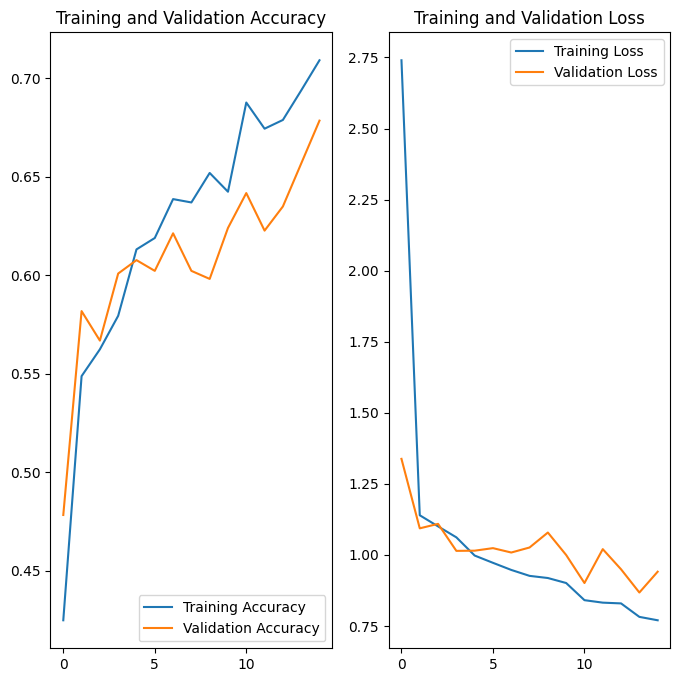

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Unfortunately, nothing much changed, with accuracy still hovering at less than .65.

## Predict on new data

In [36]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 178ms/step
This image most likely belongs to sunflowers with a 99.78 percent confidence.


The prediction confidence looks really good, though, but I'll still try a different activation.

# New Model - Leaky ReLU

In [37]:
num_classes = len(class_names)

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation=tf.keras.layers.LeakyReLU(alpha=0.02)),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation=tf.keras.layers.LeakyReLU(alpha=0.02)),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation=tf.keras.layers.LeakyReLU(alpha=0.02)),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation=tf.keras.layers.LeakyReLU(alpha=0.02)),
  layers.Dense(num_classes, name="outputs")
])

In [38]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [39]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 45, 45, 32)        0         
 ng2D)                                                

In [40]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
92/92 [==============================] - 5s 34ms/step - loss: 1.2859 - accuracy: 0.4625 - val_loss: 1.1335 - val_accuracy: 0.5436
Epoch 2/15
92/92 [==============================] - 3s 33ms/step - loss: 1.0596 - accuracy: 0.5960 - val_loss: 0.9877 - val_accuracy: 0.6199
Epoch 3/15
92/92 [==============================] - 3s 33ms/step - loss: 0.9521 - accuracy: 0.6298 - val_loss: 1.0032 - val_accuracy: 0.5913
Epoch 4/15
92/92 [==============================] - 3s 32ms/step - loss: 0.8774 - accuracy: 0.6652 - val_loss: 0.9273 - val_accuracy: 0.6458
Epoch 5/15
92/92 [==============================] - 3s 33ms/step - loss: 0.8316 - accuracy: 0.6826 - val_loss: 0.8561 - val_accuracy: 0.6853
Epoch 6/15
92/92 [==============================] - 3s 33ms/step - loss: 0.7868 - accuracy: 0.7040 - val_loss: 0.8595 - val_accuracy: 0.6635
Epoch 7/15
92/92 [==============================] - 3s 32ms/step - loss: 0.7355 - accuracy: 0.7125 - val_loss: 0.8657 - val_accuracy: 0.6608
Epoch 8/15
92

## Training Visualizations

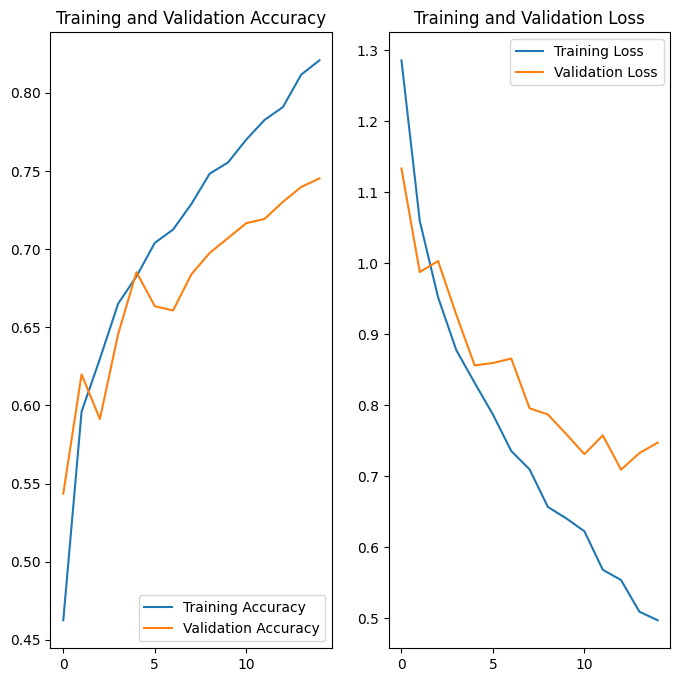

In [41]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

This is looking good, but it's about the same as the original ReLU model provided by the tutorial.

## Predict on new data

In [42]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 117ms/step
This image most likely belongs to sunflowers with a 64.78 percent confidence.


The predication confidence is much weaker, so this is not the greatest choice.

# New Model - PReLU

In [43]:
num_classes = len(class_names)

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation=tf.keras.layers.PReLU(alpha_initializer='zeros')),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation=tf.keras.layers.PReLU(alpha_initializer='zeros')),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation=tf.keras.layers.PReLU(alpha_initializer='zeros')),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation=tf.keras.layers.PReLU(alpha_initializer='zeros')),
  layers.Dense(num_classes, name="outputs")
])

In [44]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [45]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_5 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 180, 180, 16)      518848    
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 90, 90, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 90, 90, 32)        263840    
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 45, 45, 32)        0         
 ng2D)                                                

In [46]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
92/92 [==============================] - 8s 48ms/step - loss: 1.4225 - accuracy: 0.3988 - val_loss: 1.3035 - val_accuracy: 0.4441
Epoch 2/15
92/92 [==============================] - 5s 49ms/step - loss: 1.1084 - accuracy: 0.5599 - val_loss: 1.1191 - val_accuracy: 0.5463
Epoch 3/15
92/92 [==============================] - 4s 47ms/step - loss: 1.0119 - accuracy: 0.5971 - val_loss: 0.9573 - val_accuracy: 0.6158
Epoch 4/15
92/92 [==============================] - 4s 46ms/step - loss: 0.9444 - accuracy: 0.6161 - val_loss: 1.0482 - val_accuracy: 0.5749
Epoch 5/15
92/92 [==============================] - 5s 50ms/step - loss: 0.8795 - accuracy: 0.6635 - val_loss: 0.8749 - val_accuracy: 0.6322
Epoch 6/15
92/92 [==============================] - 4s 46ms/step - loss: 0.8337 - accuracy: 0.6795 - val_loss: 0.8399 - val_accuracy: 0.6676
Epoch 7/15
92/92 [==============================] - 4s 46ms/step - loss: 0.7756 - accuracy: 0.7030 - val_loss: 0.7673 - val_accuracy: 0.6921
Epoch 8/15
92

### Training Visualizations

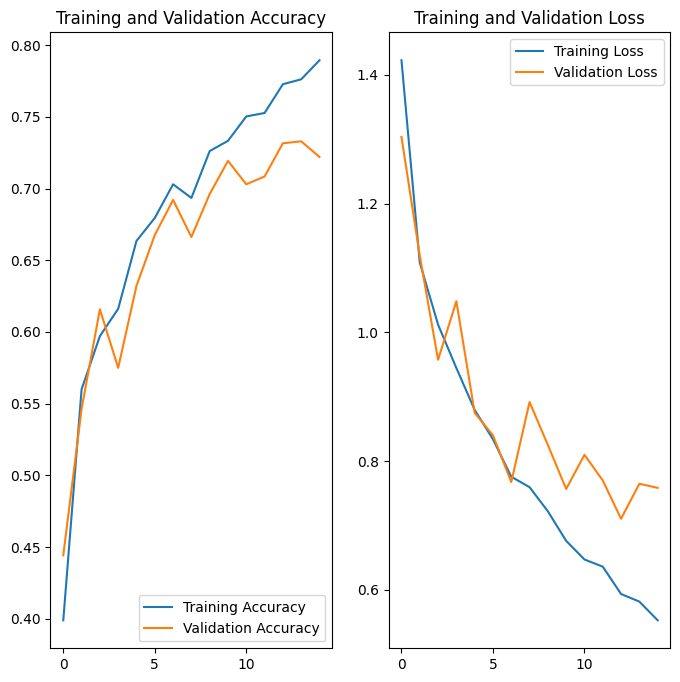

In [47]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

This looks a little better! Still not at the needed accuracy, but with some tweaking it may be better.

### Predict on new data

In [48]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 104ms/step
This image most likely belongs to sunflowers with a 99.00 percent confidence.


I don't like that the prediction confidence has decreased, but it's still very good.

## Model tuning - alpha = 0.25

I'll first try to tune the alpha initializer.

In [49]:
def custom_alpha_initializer(shape, dtype=None):
    # Define your custom initialization logic here
    # For example, you can initialize all alphas with a specific value, e.g., 0.25
    alpha_value = 0.25
    return tf.constant(alpha_value, shape=shape, dtype=dtype)


In [50]:
num_classes = len(class_names)

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation=tf.keras.layers.PReLU(alpha_initializer=custom_alpha_initializer)),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation=tf.keras.layers.PReLU(alpha_initializer=custom_alpha_initializer)),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation=tf.keras.layers.PReLU(alpha_initializer=custom_alpha_initializer)),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation=tf.keras.layers.PReLU(alpha_initializer=custom_alpha_initializer)),
  layers.Dense(num_classes, name="outputs")
])

In [51]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [52]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_6 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 180, 180, 16)      518848    
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 90, 90, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_16 (Conv2D)          (None, 90, 90, 32)        263840    
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 45, 45, 32)        0         
 ng2D)                                                

In [53]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
92/92 [==============================] - 8s 48ms/step - loss: 1.2315 - accuracy: 0.5160 - val_loss: 1.1309 - val_accuracy: 0.5627
Epoch 2/15
92/92 [==============================] - 4s 46ms/step - loss: 0.9808 - accuracy: 0.6117 - val_loss: 1.0194 - val_accuracy: 0.6117
Epoch 3/15
92/92 [==============================] - 4s 47ms/step - loss: 0.9001 - accuracy: 0.6417 - val_loss: 1.0647 - val_accuracy: 0.5736
Epoch 4/15
92/92 [==============================] - 4s 46ms/step - loss: 0.8437 - accuracy: 0.6744 - val_loss: 0.8365 - val_accuracy: 0.6757
Epoch 5/15
92/92 [==============================] - 4s 49ms/step - loss: 0.7778 - accuracy: 0.7013 - val_loss: 0.7963 - val_accuracy: 0.6935
Epoch 6/15
92/92 [==============================] - 4s 49ms/step - loss: 0.7414 - accuracy: 0.7115 - val_loss: 0.7752 - val_accuracy: 0.6989
Epoch 7/15
92/92 [==============================] - 4s 46ms/step - loss: 0.7104 - accuracy: 0.7296 - val_loss: 0.8046 - val_accuracy: 0.6962
Epoch 8/15
92

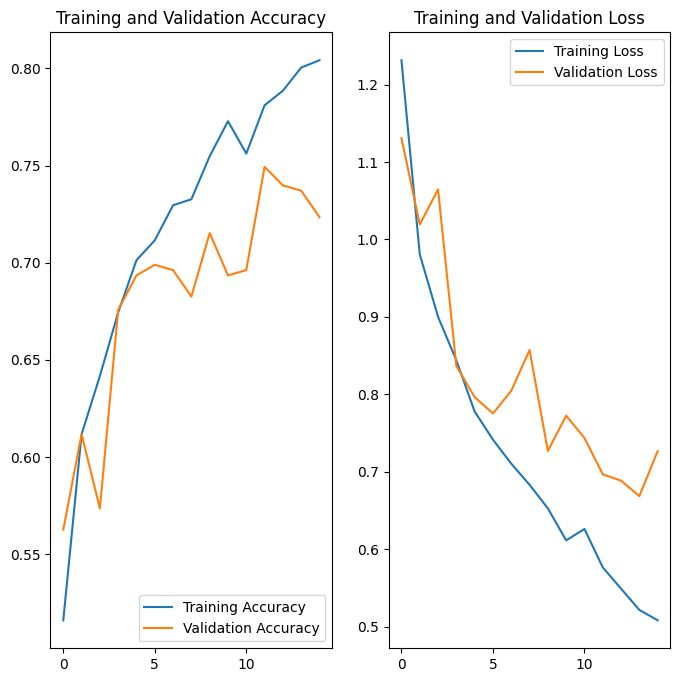

In [54]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Still not fantastic, but improved! I'll keep trying with other alphas.

In [55]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 106ms/step
This image most likely belongs to sunflowers with a 96.82 percent confidence.


## Model tuning - alpha = 0.5

In [56]:
def custom_alpha_initializer(shape, dtype=None):
    # Define your custom initialization logic here
    # For example, you can initialize all alphas with a specific value, e.g., 0.25
    alpha_value = 0.5
    return tf.constant(alpha_value, shape=shape, dtype=dtype)


In [57]:
num_classes = len(class_names)

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation=tf.keras.layers.PReLU(alpha_initializer=custom_alpha_initializer)),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation=tf.keras.layers.PReLU(alpha_initializer=custom_alpha_initializer)),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation=tf.keras.layers.PReLU(alpha_initializer=custom_alpha_initializer)),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation=tf.keras.layers.PReLU(alpha_initializer=custom_alpha_initializer)),
  layers.Dense(num_classes, name="outputs")
])

In [58]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [59]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_7 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_18 (Conv2D)          (None, 180, 180, 16)      518848    
                                                                 
 max_pooling2d_18 (MaxPooli  (None, 90, 90, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_19 (Conv2D)          (None, 90, 90, 32)        263840    
                                                                 
 max_pooling2d_19 (MaxPooli  (None, 45, 45, 32)        0         
 ng2D)                                                

In [60]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
92/92 [==============================] - 8s 48ms/step - loss: 1.6312 - accuracy: 0.4380 - val_loss: 1.2255 - val_accuracy: 0.4837
Epoch 2/15
92/92 [==============================] - 4s 46ms/step - loss: 1.1089 - accuracy: 0.5569 - val_loss: 1.0593 - val_accuracy: 0.5886
Epoch 3/15
92/92 [==============================] - 4s 46ms/step - loss: 1.0588 - accuracy: 0.5807 - val_loss: 1.0218 - val_accuracy: 0.6158
Epoch 4/15
92/92 [==============================] - 4s 46ms/step - loss: 0.9690 - accuracy: 0.6182 - val_loss: 1.0350 - val_accuracy: 0.6049
Epoch 5/15
92/92 [==============================] - 4s 47ms/step - loss: 0.9132 - accuracy: 0.6509 - val_loss: 1.0071 - val_accuracy: 0.6049
Epoch 6/15
92/92 [==============================] - 4s 46ms/step - loss: 0.8767 - accuracy: 0.6655 - val_loss: 0.9136 - val_accuracy: 0.6621
Epoch 7/15
92/92 [==============================] - 4s 46ms/step - loss: 0.8471 - accuracy: 0.6727 - val_loss: 0.9113 - val_accuracy: 0.6621
Epoch 8/15
92

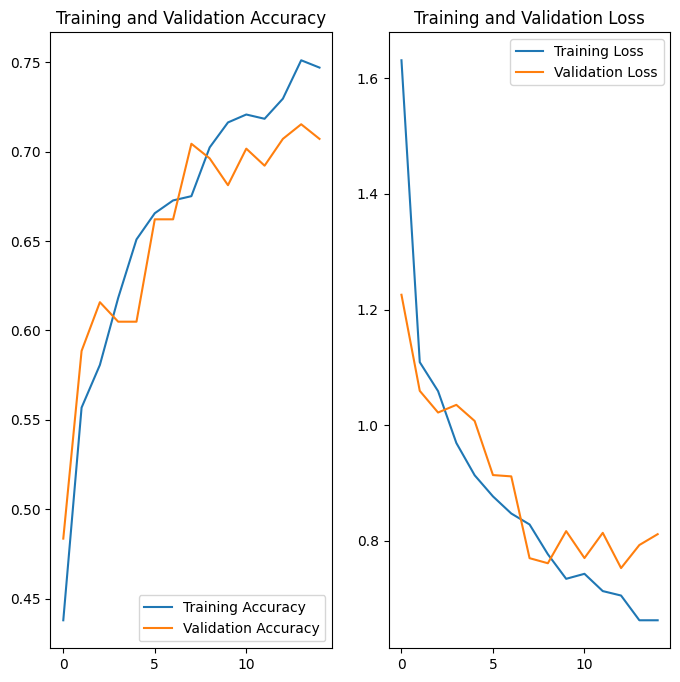

In [61]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Getting close! I'll increase the alpha again.

In [62]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 129ms/step
This image most likely belongs to tulips with a 63.06 percent confidence.


## Model tuning - alpha = 0.6


In [63]:
def custom_alpha_initializer(shape, dtype=None):
    # Define your custom initialization logic here
    # For example, you can initialize all alphas with a specific value, e.g., 0.25
    alpha_value = 0.6
    return tf.constant(alpha_value, shape=shape, dtype=dtype)


In [64]:
num_classes = len(class_names)

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation=tf.keras.layers.PReLU(alpha_initializer=custom_alpha_initializer)),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation=tf.keras.layers.PReLU(alpha_initializer=custom_alpha_initializer)),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation=tf.keras.layers.PReLU(alpha_initializer=custom_alpha_initializer)),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation=tf.keras.layers.PReLU(alpha_initializer=custom_alpha_initializer)),
  layers.Dense(num_classes, name="outputs")
])

In [65]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [66]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_8 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_21 (Conv2D)          (None, 180, 180, 16)      518848    
                                                                 
 max_pooling2d_21 (MaxPooli  (None, 90, 90, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_22 (Conv2D)          (None, 90, 90, 32)        263840    
                                                                 
 max_pooling2d_22 (MaxPooli  (None, 45, 45, 32)        0         
 ng2D)                                                

In [67]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
92/92 [==============================] - 8s 48ms/step - loss: 1.4703 - accuracy: 0.4775 - val_loss: 1.1483 - val_accuracy: 0.5586
Epoch 2/15
92/92 [==============================] - 4s 48ms/step - loss: 1.0740 - accuracy: 0.5749 - val_loss: 1.1298 - val_accuracy: 0.5668
Epoch 3/15
92/92 [==============================] - 4s 46ms/step - loss: 0.9925 - accuracy: 0.6127 - val_loss: 0.9772 - val_accuracy: 0.6226
Epoch 4/15
92/92 [==============================] - 4s 46ms/step - loss: 0.9163 - accuracy: 0.6468 - val_loss: 0.9152 - val_accuracy: 0.6553
Epoch 5/15
92/92 [==============================] - 4s 47ms/step - loss: 0.9093 - accuracy: 0.6393 - val_loss: 1.1579 - val_accuracy: 0.6049
Epoch 6/15
92/92 [==============================] - 4s 47ms/step - loss: 0.8883 - accuracy: 0.6567 - val_loss: 0.9352 - val_accuracy: 0.6349
Epoch 7/15
92/92 [==============================] - 4s 47ms/step - loss: 0.8506 - accuracy: 0.6676 - val_loss: 0.8665 - val_accuracy: 0.6771
Epoch 8/15
92

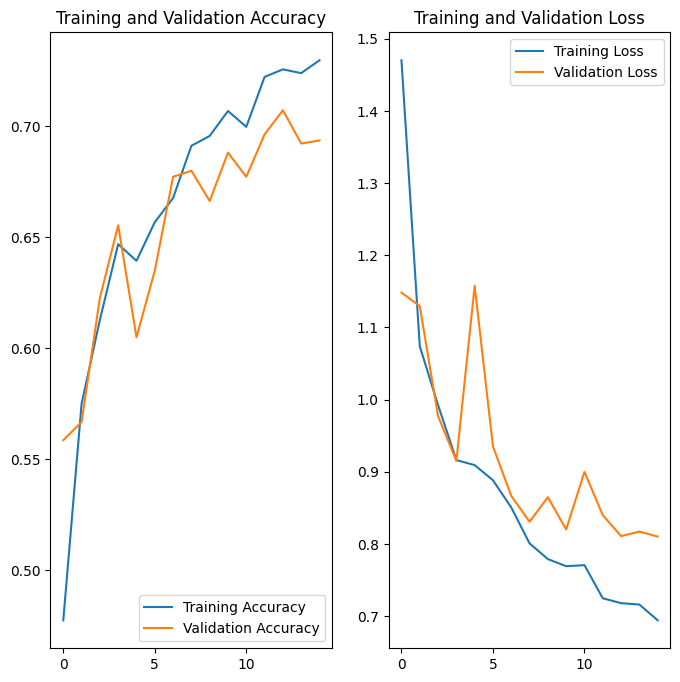

In [68]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

It got worse--let's try slightly below 0.5.

In [69]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 104ms/step
This image most likely belongs to roses with a 45.83 percent confidence.


## Model Tuning - alpha = 0.45

In [70]:
def custom_alpha_initializer(shape, dtype=None):
    # Define your custom initialization logic here
    # For example, you can initialize all alphas with a specific value, e.g., 0.25
    alpha_value = 0.45
    return tf.constant(alpha_value, shape=shape, dtype=dtype)


In [71]:
num_classes = len(class_names)

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation=tf.keras.layers.PReLU(alpha_initializer=custom_alpha_initializer)),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation=tf.keras.layers.PReLU(alpha_initializer=custom_alpha_initializer)),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation=tf.keras.layers.PReLU(alpha_initializer=custom_alpha_initializer)),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation=tf.keras.layers.PReLU(alpha_initializer=custom_alpha_initializer)),
  layers.Dense(num_classes, name="outputs")
])

In [72]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [73]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_9 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_24 (Conv2D)          (None, 180, 180, 16)      518848    
                                                                 
 max_pooling2d_24 (MaxPooli  (None, 90, 90, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_25 (Conv2D)          (None, 90, 90, 32)        263840    
                                                                 
 max_pooling2d_25 (MaxPooli  (None, 45, 45, 32)        0         
 ng2D)                                                

In [74]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
92/92 [==============================] - 8s 52ms/step - loss: 1.3956 - accuracy: 0.4663 - val_loss: 1.1058 - val_accuracy: 0.5654
Epoch 2/15
92/92 [==============================] - 4s 46ms/step - loss: 1.0608 - accuracy: 0.5797 - val_loss: 1.1006 - val_accuracy: 0.5490
Epoch 3/15
92/92 [==============================] - 4s 46ms/step - loss: 1.0010 - accuracy: 0.6073 - val_loss: 1.0221 - val_accuracy: 0.6063
Epoch 4/15
92/92 [==============================] - 4s 49ms/step - loss: 0.9470 - accuracy: 0.6284 - val_loss: 0.9325 - val_accuracy: 0.6403
Epoch 5/15
92/92 [==============================] - 4s 46ms/step - loss: 0.8650 - accuracy: 0.6580 - val_loss: 0.9220 - val_accuracy: 0.6417
Epoch 6/15
92/92 [==============================] - 4s 45ms/step - loss: 0.8487 - accuracy: 0.6659 - val_loss: 0.8389 - val_accuracy: 0.6894
Epoch 7/15
92/92 [==============================] - 4s 47ms/step - loss: 0.7733 - accuracy: 0.6979 - val_loss: 0.8927 - val_accuracy: 0.6676
Epoch 8/15
92

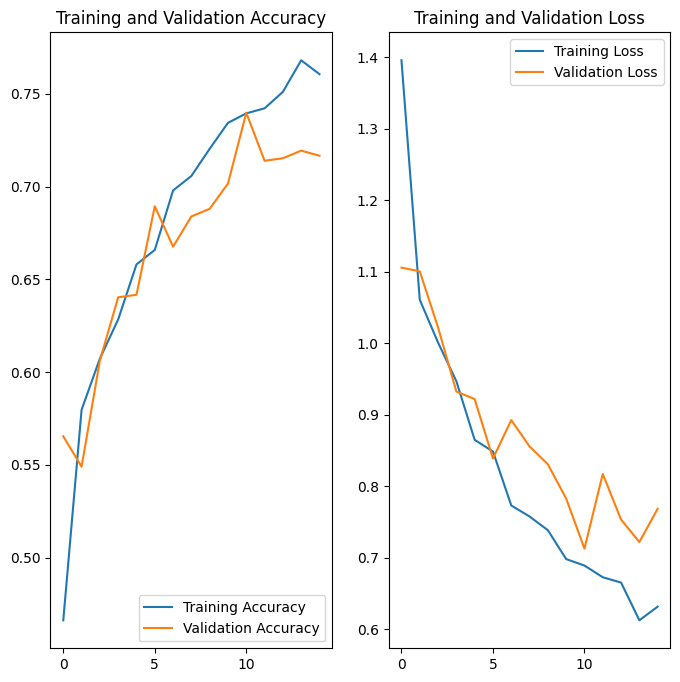

In [75]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

This still hasn't improved.

In [76]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 104ms/step
This image most likely belongs to sunflowers with a 97.47 percent confidence.


# Model Selection

Out of all of these, I would choose the PReLU model with an alpha of 0.25. It had the best accuracy of any of the models I tested and had a good prediction confidence.